# Markov chain approach on (not augmented) sociopatterns data 

See Eq.(3.13) in Iacopini, I. (2021). [Modelling the social dynamics of contagion and discovery using dynamical processes on complex networks](https://qmro.qmul.ac.uk/xmlui/handle/123456789/70668) (Doctoral dissertation, Queen Mary University of London.).

In [1]:
import networkx as nx
import numpy as np
from utils_simplagion_MC import *
import random as rd

import matplotlib.pyplot as plt
%matplotlib inline 

Markov chain function

In [3]:
def markovChain(beta, beta_D, mu, node_neighbors_dict, tri_neighbors_dict, NSteps, i0):
    N = len(node_neighbors_dict)
    p = np.zeros(N)
    p[rd.sample(range(N),int(N*i0))] = 1
    p_new = np.copy(p)
    
    q = 1
    pTime = [np.mean(p)]
    for k in range(0,NSteps):
        for i in range(0,N):
            
            #Updating the q_i (infections) - d=1
            for j in node_neighbors_dict[i]:
                q *= (1.-beta*p[j])
                
            #Updating the q_i (infections) - d=2
            for j, k in tri_neighbors_dict[i]:
                q *= (1.-beta_D*p[j]*p[k])
            
            #Updating the vector
            p_new[i] = (1-q)*(1-p[i]) + (1.-mu)*p[i]
            
            #Resetting the i-th parameters
            q = 1
            
        p = np.copy(p_new)
        pTime.append(np.mean(p))
    return np.mean(pTime[int(NSteps*0.8):])

Reading clean Sociopatterns data

In [4]:
dataset_dir = 'Data/Sociopatterns/thr_data_random/'
dataset = 'Thiers13'#'InVS15','SFHH', 'LH10','LyonSchool'
n_minutes = 5 #Aggregation time
thr = 0.80 #fraction of removed cliques (0.80: retaining the 20% most weighted)

node_neighbors_dict, triangles_list, avg_k1, avg_k2 = import_sociopattern_simcomp_SCM(dataset_dir, dataset, n_minutes, thr)
tri_neighbors_dict = get_tri_neighbors_dict(triangles_list)

mu = 0.05
lambda1s = np.linspace(0.0001,1.5,20)
lambdaD_target_list = [2.5,2.5,0]
I_percentage_list = [40,1,1]

betas = 1.*(mu/avg_k1)*lambda1s

NSteps = 500

Running Makov and saving it to a single list of lists

In [5]:
markov_results = []

for lambdaD_target, I_percentage in zip(lambdaD_target_list, I_percentage_list):
    beta_D = 1.*(mu/avg_k2)*lambdaD_target
    i0 = I_percentage/100.
    rho_markov = [markovChain(beta, beta_D, mu, node_neighbors_dict, tri_neighbors_dict, NSteps, i0) for beta in betas]
    markov_results.append(rho_markov)

C:\Users\北村拓也\AppData\Local\Temp\ipykernel_16140\729815391.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(lambda1s, rho, '-o', color=linecolor[j], lw=1.5, marker=markers[j],


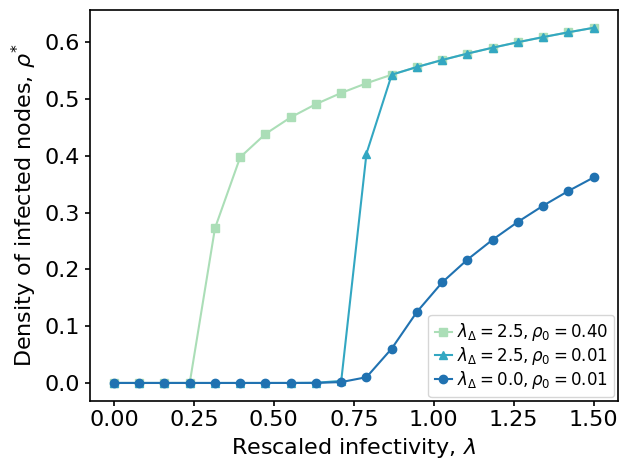

In [6]:
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

markers = ['s', '^', 'o']
linecolor = [plt.cm.YlGnBu(0.3), plt.cm.YlGnBu(0.55), plt.cm.YlGnBu(0.7)]

ax = plt.subplot(111)

for j, rho in enumerate(markov_results):
    ax.plot(lambda1s, rho, '-o', color=linecolor[j], lw=1.5, marker=markers[j],
            label=r'$\lambda_\Delta=%.1f, \rho_0=%.2f$'%(lambdaD_target_list[j], 0.01*I_percentage_list[j]))
        
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Rescaled infectivity, $\lambda$', size=16)
ax.set_ylabel(r'Density of infected nodes, $\rho^{*}$', size=16)
ax.legend(fontsize=12, handlelength=1, handletextpad=0.3, labelspacing=0.1, borderaxespad=0.2, loc=4)  

plt.tight_layout()